In [1]:
import os
import caesar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import modules as anal
import modules.anal_func as anal_func

from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.io import fits
from scipy import interpolate


cosmo = LambdaCDM(H0 = 68, Om0= 0.3, Ode0= 0.7, Ob0=0.048)
plt.rcParams.update({'font.size': 28})

In [2]:
# initialize the Simba class, which import the needed paths
sb = anal.Simba('PC39BP4', size=100)
# initialize the SavePaths class to create destinations
sv = anal.SavePaths() 
pltsv  = sv.get_filetype_path('plot')
scatter = sv.create_subdir(pltsv, 'scatter')

In [3]:
# I will work with a single snapshot for now
snap = 129
cs = sb.get_caesar(snap)
a = cs.simulation.scale_factor
z = sb.get_redshifts()
clust_mass_thresh = 1e14

yt : [INFO     ] 2024-08-15 19:07:09,866 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_129.hdf5
yt : [INFO     ] 2024-08-15 19:07:09,886 Found 495012 halos
yt : [INFO     ] 2024-08-15 19:07:09,927 Found 46575 galaxies


In [4]:
# We want all central galaxies in clusters
central_gal_ind = np.asarray([i.GroupID for i in cs.galaxies if i.central==1]) # select central galaxies
print('Total number of central galaxies: ', len(central_gal_ind))
gals_in_clusters = [i.galaxy_index_list for i in cs.halos if i.masses['total']>clust_mass_thresh] # galaxies in masive halos
gals_in_clusters = np.concatenate(gals_in_clusters)
print(f'Total number of Mtot above {clust_mass_thresh} Msun: ', len(gals_in_clusters))
central_in_cluster_id = central_gal_ind[np.isin(central_gal_ind, gals_in_clusters)]
print('Total number of central galaxies in clusters: ', len(central_in_cluster_id))

Total number of central galaxies:  30429
Total number of Mtot above 100000000000000.0 Msun:  2363
Total number of central galaxies in clusters:  24


In [5]:
# Now that we have filtered the needed galaxies we can study their properties
Ms      = np.asarray([i.masses['stellar'] for i in cs.galaxies])[central_in_cluster_id]
Mh2     = np.asarray([i.masses['H2'] for i in cs.galaxies])[central_in_cluster_id]
Mh1     = np.asarray([i.masses['HI'] for i in cs.galaxies])[central_in_cluster_id]
Md      = np.asarray([i.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]
sfr     = np.asarray([i.sfr for i in cs.galaxies])[central_in_cluster_id]
ages    = np.asarray([i.ages['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
bh_fedd = np.asarray([i.bh_fedd for i in cs.galaxies])[central_in_cluster_id]
bh_mass = np.asarray([i.masses['bh'] for i in cs.galaxies])[central_in_cluster_id]
met     = np.asarray([i.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
met_cgm = np.asarray([i.metallicities['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]
T       = np.asarray([i.temperatures['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
T_cgm   = np.asarray([i.temperatures['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]

In [6]:
# we want also the info on the corresponding halos
Mhalo      = np.asarray([i.halo.masses['total'] for i in cs.galaxies])[central_in_cluster_id]
Mhalo_h2   = np.asarray([i.halo.masses['H2'] for i in cs.galaxies])[central_in_cluster_id] - Mh2
Mhalo_h1   = np.asarray([i.halo.masses['HI'] for i in cs.galaxies])[central_in_cluster_id] - Mh1
Mhalo_dust = np.asarray([i.halo.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]-Md
methalo    = np.asarray([i.halo.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
Tvir       = np.asarray([i.halo.virial_quantities['temperature'] for i in cs.galaxies])[central_in_cluster_id]

In [7]:
# calculate oxygen abundance and DTM
logoh12 = anal_func.Z_to_OH12(met)
logoh12_h = anal_func.Z_to_OH12(methalo)
dtm     = anal_func.Dust_to_Metal(Md, Mh2, logoh12)

In [8]:
# Let's see how many satellites there are for each galaxy:
from modules.anal_func.side_functions.search import findsatellites
r = 50
pos = np.asarray([i.pos for i in cs.galaxies])
sat_ids = findsatellites(pos, sb, snap, r)

yt : [INFO     ] 2024-08-14 09:38:48,947 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_129.hdf5
yt : [INFO     ] 2024-08-14 09:38:48,955 Found 495012 halos
yt : [INFO     ] 2024-08-14 09:38:48,958 Found 46575 galaxies


In [ ]:
# DGR vs Mhalo colored with metallicity (black points are those with no dust at all)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nodust = Md == 0
sc = ax.scatter(np.log10(Mhalo), np.log10(Md / Mh2), c=logoh12, s=100)
ax.scatter(np.log10(Mhalo)[nodust], -6.5*np.ones(len(Ms[nodust])), c='k', s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm O/H)+12$')
ax.set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')
fig.savefig(os.path.join(scatter, 'DGR_Mhalo_met.png'), bbox_inches = 'tight')

In [ ]:
# DGR vs Mhalo colore with fraction of dust in the halo wrt in the satellites around the central (distance r)
nsat = np.asarray([len(sat_ids[i]) for i in sat_ids])
Md_tot      = np.asarray([i.masses['dust'] for i in cs.galaxies])
Ms_tot      = np.asarray([i.masses['stellar'] for i in cs.galaxies])
dustsat = np.asarray([sum(Md_tot[sat_ids[i]]) for i in sat_ids])
masssat = np.asarray([sum(Ms_tot[sat_ids[i]]) for i in sat_ids])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=Mhalo_dust/dustsat, norm=colors.LogNorm(), s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, halo}/M_{\rm dust, satell.}$')
ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')
fig.savefig(os.path.join(scatter, 'DGR_Mhalo_dustinhalo.png'), bbox_inches = 'tight')

In [ ]:
# Comparison with dust/star in the satellites around the central (at distance r) vs the fraction of dust diffused in the halo (so not in galaxies)
# colored with the dust fraction i n the central
# The size represents the number of satellites
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
minreplace = dustsat[dustsat!=0].min()-0.3*dustsat[dustsat!=0].min()
#dustsat[dustsat==0] = minreplace #pay attention here: run cell only once
#ax.axhline(np.log10(minreplace), ls='--', c='r')
sc = plt.scatter(np.log10(Mhalo_dust/Mhalo), np.log10(dustsat/Ms), c=Md/Ms, s=nsat*20, norm=colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, central}/M_{\star}$')
ax.set_xlabel(r'$\log(M_{\rm dust, halo}/M_{\rm tot})$')
ax.set_ylabel(r'$\log(M_{\rm dust, satell.}/M_{\rm central})$')
ax.set_title(f'Satellites in r={r} kpc')
plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/20))
fig.savefig(os.path.join(scatter, 'dust_sat_halo_cent.png'), bbox_inches = 'tight')

In [9]:
# from modules.anal_func.filter_particles import copy_skeleton, filter_particles_by_obj
# sb = anal.Simba('PC39BP4', size=25)
# filter_particles_by_obj(cs, sb.get_sim_file(snap), snap, 'galaxy', [0,1], verbose=0, overwrite=True, ignore_fields=[], keyword=None)

Finished with particle filters


In [2]:
from modules.anal_func.read_progenitors import read_progen
sb = anal.Simba('PC39BP4', size=100)
cs = sb.get_caesar(150)
totids = np.asarray([i.GroupID for i in cs.galaxies])
read_progen(totids, 'progenitors_most_mass_nocaesar.fits', np.arange(44, 150, 1).astype(int), sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5')

yt : [INFO     ] 2024-08-15 13:47:11,995 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_150.hdf5
yt : [INFO     ] 2024-08-15 13:47:12,017 Found 465211 halos
yt : [INFO     ] 2024-08-15 13:47:12,058 Found 55336 galaxies


Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_149.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_148.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_147.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_146.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_145.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_144.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_143.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_142.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_141.fits
Processing

In [4]:
# initialize the Simba class, which import the needed paths
sb = anal.Simba('PC39BP4', size=100)
# initialize the SavePaths class to create destinations
sv = anal.SavePaths() 
pltsv  = sv.get_filetype_path('plot')
scatter = sv.create_subdir(pltsv, 'scatter')

In [5]:
from modules.anal_func.build_history import BuildHistory
from modules.anal_func.read_progenitors import read_progen
sb = anal.Simba('PC39BP4', size=100)
cs = sb.get_caesar(150)
totids = np.asarray([i.GroupID for i in cs.galaxies])
sb = anal.Simba('PC39BP4', size=100)
sfh = BuildHistory(sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5', progfilename='progenitors_most_mass_nocaesar.fits')

yt : [INFO     ] 2024-08-15 19:07:13,833 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_150.hdf5
yt : [INFO     ] 2024-08-15 19:07:13,866 Found 465211 halos
yt : [INFO     ] 2024-08-15 19:07:13,872 Found 55336 galaxies


In [6]:
hist = sfh.get_history_indx(totids[:1000], start_snap=44, end_snap=149)

In [7]:
sfr = sfh.get_property_history(['pos_0', 'pos_1', 'stellar_masses', 'sfr', 'GroupID'])

Number of snapshots: 106
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_044.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_045.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_046.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_047.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_048.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_049.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_050.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_051.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_052.fits
Opening /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_053.fits
Opening /home/lorenzong/analize_simba_cgm/out

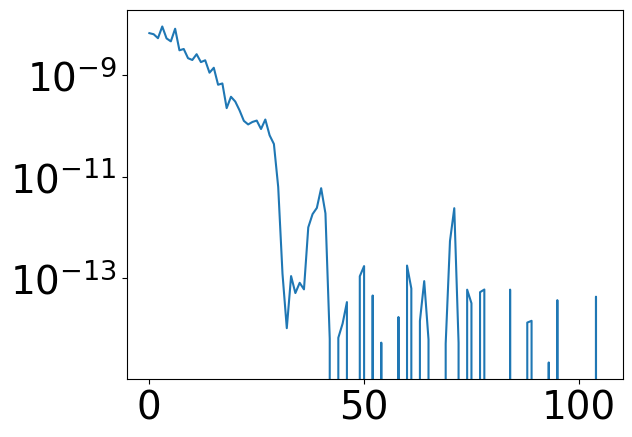

In [8]:
plt.plot((sfr['sfr']/sfr['stellar_masses'])[:,2])
plt.yscale('log')

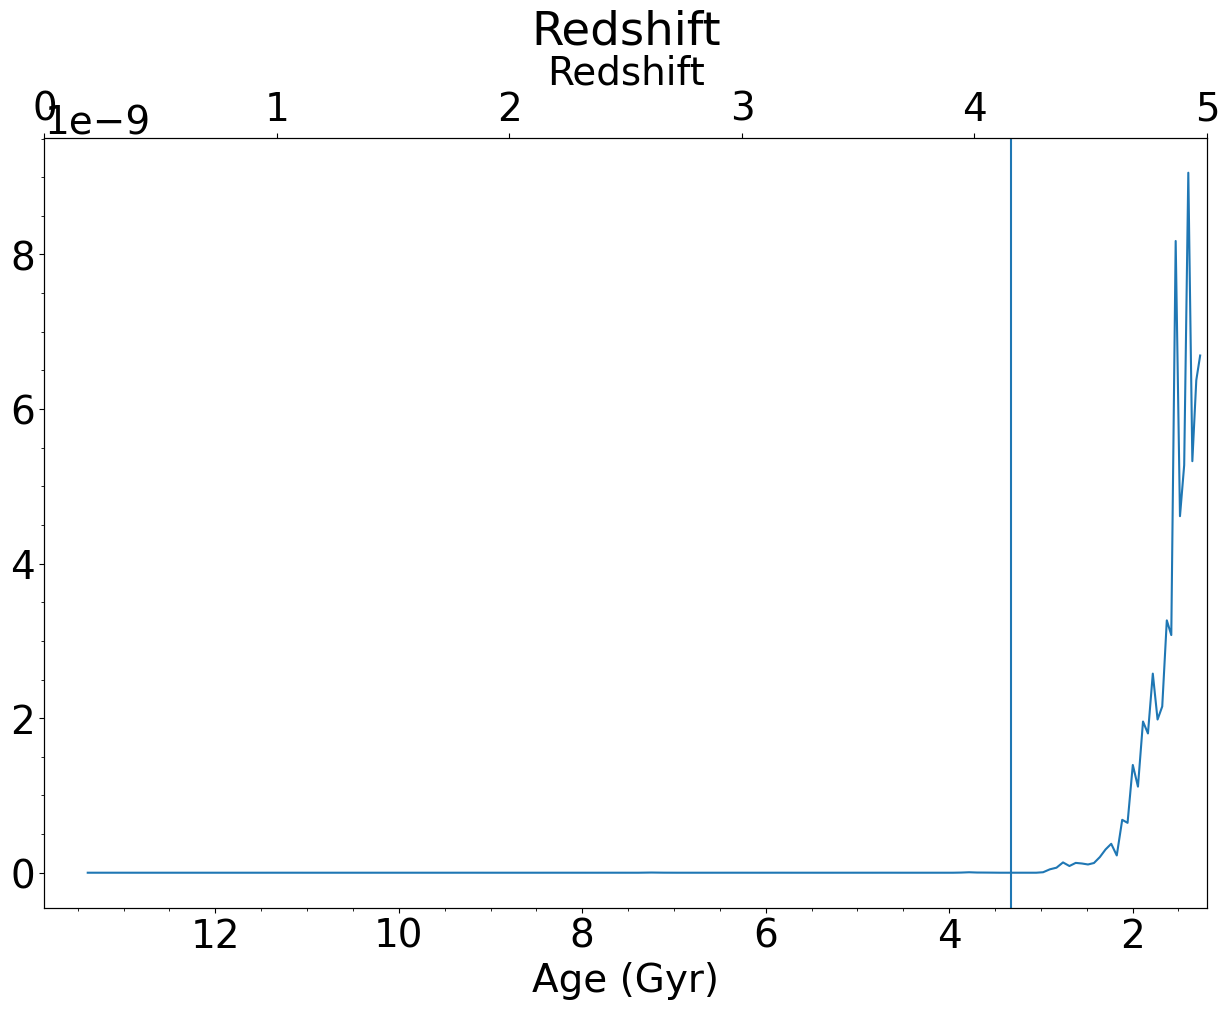

In [9]:
sfh.plot_history([0, 1, 2, 3, 4, 5], cosmo, 2)